## Posteriori Balancing Notebook
---

In this notebook we will focus on posteriori data balancing. This means that we focus on the extracted features, and we try to balance the data by using undersampling and oversampling techniques.

1. [Load Data](#Load-Data)
2. [Feature Distribution](#Feature-Distribution)
3. [Feature Balancing](#Feature-Balancing)

In [1]:
# import all the functions
from utils import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### 1. Load Data <a id='Load-Data'></a>

In [2]:
# paths to the features and the labels
FEATURES_RAW_DIR = '../features/raw/'
FEATURES_PROC_DIR = '../features/processed/'
DIRS = [FEATURES_RAW_DIR, FEATURES_PROC_DIR]

#### 2. Feature Distribution <a id='Feature-Distribution'></a>

artifacts_base_1_mix.npz features   -   Label: 0.0
Max: 21160.455953663793, Min: -1131.369384765625, Mean: 483.97492510688136, Std: 1852.854843619321      -       Shape: (2000, 26)

extrastoles_base_1_mix.npz features   -   Label: 4.0
Max: 1057.6171875, Min: -309.2425537109375, Mean: 37.46883951805036, Std: 130.15941934366995      -       Shape: (247, 26)

extrahls_base_1_mix.npz features   -   Label: 1.0
Max: 18953.178879310344, Min: -674.0330810546875, Mean: 753.7483613723052, Std: 2587.231366594324      -       Shape: (124, 26)

murmurs_base_1_mix.npz features   -   Label: 2.0
Max: 13025.607825969828, Min: -574.7505493164062, Mean: 105.72155305406422, Std: 538.6539669046897      -       Shape: (1149, 26)

normals_base_1_mix.npz features   -   Label: 3.0
Max: 16976.08432112069, Min: -654.86279296875, Mean: 111.12140859068722, Std: 738.1790744503893      -       Shape: (2161, 26)



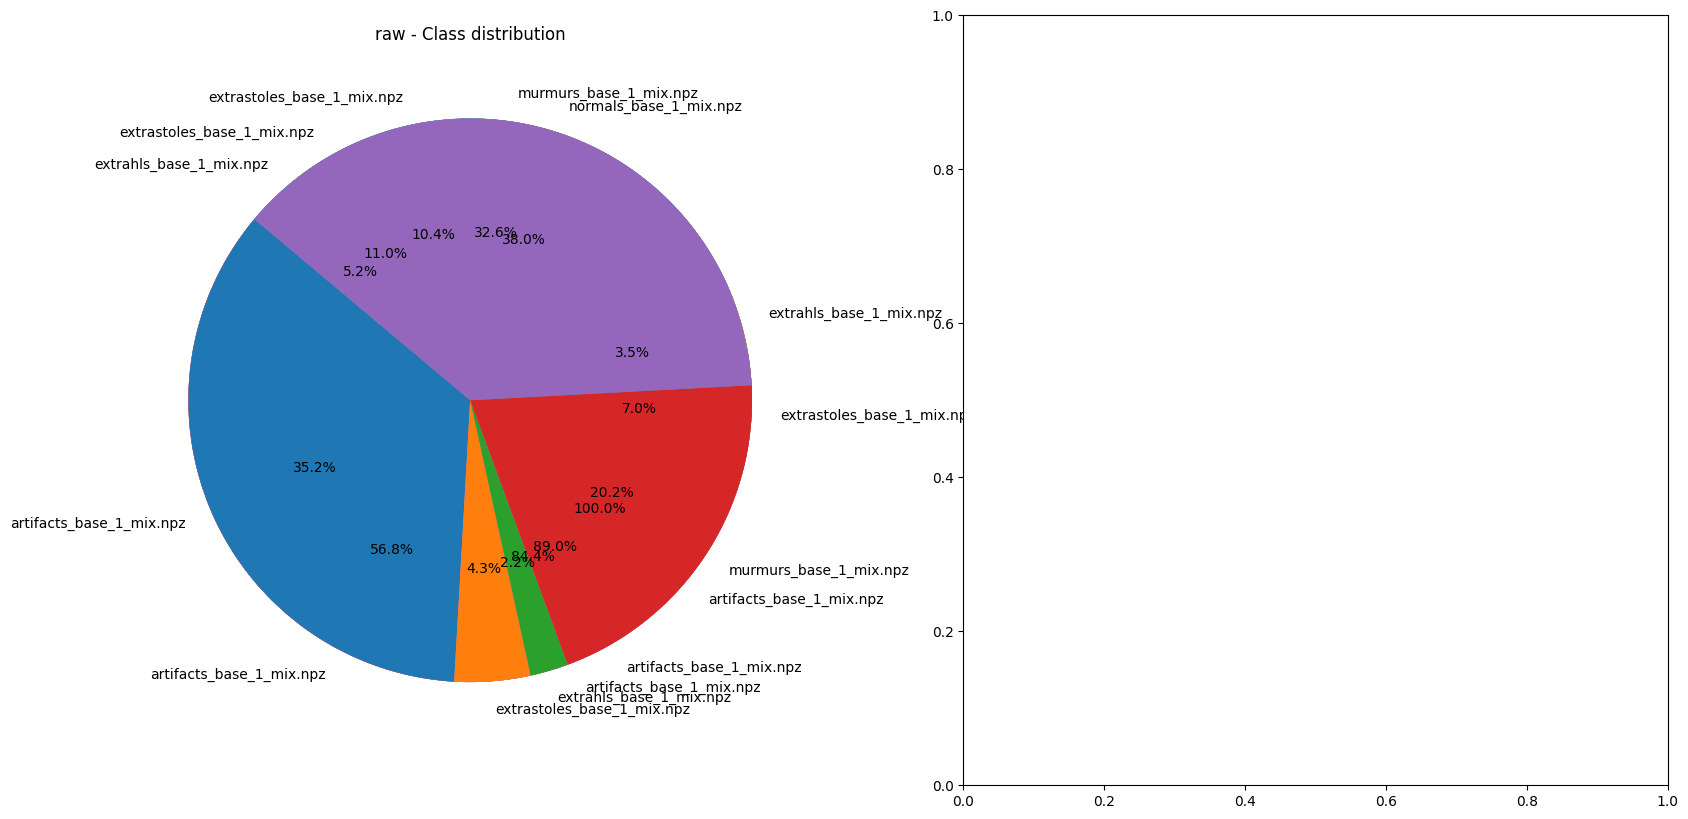

In [6]:
# basics statistics
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

for i, DIR in enumerate(DIRS):
	names = os.listdir(DIR)
	shapes = []
	name_labels = {}

	for name in names:
		features = np.load(DIR + name)['X']
		label = np.load(DIR + name)['y'][0]
		name_labels[name] = label
		max = features.max()
		min = features.min()
		mean = features.mean()
		std = features.std()
		print(f'{name} features   -   Label: {label}')
		print(f'Max: {max}, Min: {min}, Mean: {mean}, Std: {std}      -       Shape: {features.shape}\n')
		shapes.append(features.shape[0])

		title = DIR.split('/')[-2]
		axs[i].pie(shapes, labels = name_labels.keys(), autopct='%1.1f%%', startangle=140)
		axs[i].set_title(f'{title} - Class distribution')

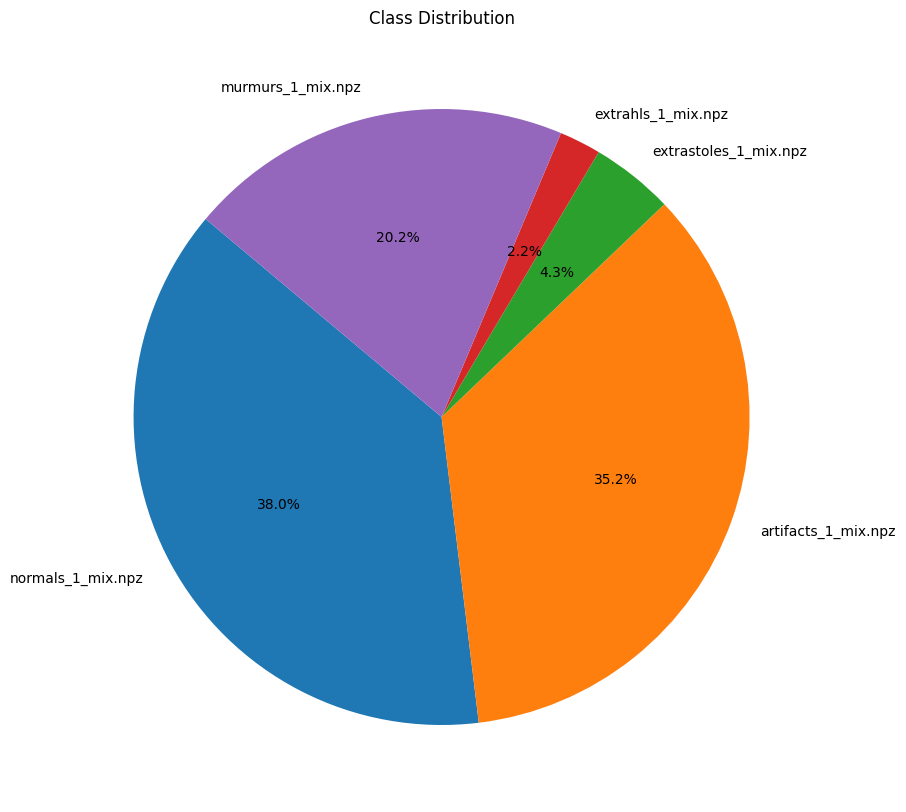

In [ ]:
# use a cake chart to show the class distribution OF RAW VS PROCESSED
fig, axs = plt.subplots(1, 2, figsize=(20, 10))


plt.pie(shapes, labels = name_labels.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.show()

#### 3. Feature Balancing <a id='Feature-Balancing'></a>

To address the problem of class imbalance, we have different options:
- **Undersampling**: randomly remove samples from the majority class. However the high difference in the number of samples between classes may lead to a loss of information. This approach may be viable, reducing the frame window size, to enlarge the number of samples in the minority class. We skip this approach for now.
- **Classic Oversampling**: randomly duplicate samples from the minority class. This approach may lead to overfitting, as the model may learn the same samples multiple times. We skip this approach for now.
- **SMOTE (Synthetic Minority Over-sampling Technique)**: generate synthetic samples from the minority class. This approach may be more robust than the classic oversampling, as it generates new samples based on the existing ones. We will use this approach to balance the classes.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTEN
from collections import Counter

# --------------------------------------------------------------------
# --------------------------------------------------------------------


def rebalance_data(data_to_balance, target_size, random_seed, get_np_arrays=True):
     """
     Rebalances the data to target size using RandomOverSampler and RandomUnderSampler. Specifically, it will first oversample the data below the
     target size and then undersample the data above the target size. The random seed is used to ensure reproducibility.

     Args:
     data_to_balance (dict): The data to balance. It should be a dictionary where the keys are the class labels and the values are the data.
     target_size (int): The target size for each class.
     random_seed (int): The random seed to use for reproducibility.
     get_np_arrays (bool, optional): If True, the function will return the balanced data as numpy arrays. If False, the function will return the balanced data as a dictionary. Defaults to True.

     Returns:
     dict or numpy.ndarray: The balanced data. If `get_np_arrays` is True, the balanced data will be returned as a dictionary of numpy arrays, where the keys are the class labels and the values are the balanced data arrays. If `get_np_arrays` is False, the balanced data will be returned as a dictionary, where the keys are the class labels and the values are the balanced data.
     """
     
     # Get the class labels
     class_labels = list(data_to_balance.keys())
     
     # Get the data
     data = list(data_to_balance.values())
     
     # Get the class distribution
     class_distribution = Counter([len(data[i]) for i in range(len(data))])
     
     # Get the maximum and minimum class size
     max_class_size = max(class_distribution.keys())
     min_class_size = min(class_distribution.keys())
     
     # Get the classes below and above the target size
     classes_below_target_size = [class_labels[i] for i in range(len(data)) if len(data[i]) < target_size]
     classes_above_target_size = [class_labels[i] for i in range(len(data)) if len(data[i]) > target_size]
     
     # Oversample the classes below the target size by generating synthetic samples uing the SMOTE algorithm (SMOTEN is specific for categorical features)
     oversampled_data = {}
     for class_label in classes_below_target_size:
          oversampled_data[class_label] = SMOTEN(sampling_strategy={class_label: target_size}, random_state=random_seed).fit_resample(data[class_labels.index(class_label)], data[class_labels.index(class_label)])[0]
     
     # Undersample the classes above the target size
     undersampled_data = {}
     for class_label in classes_above_target_size:
          undersampled_data[class_label] = RandomUnderSampler(sampling_strategy={class_label: target_size}, random_state=random_seed).fit_resample(data[class_labels.index(class_label)], data[class_labels.index(class_label)])[0]
     
     # Combine the oversampled and undersampled data
     balanced_data = {**oversampled_data, **undersampled_data}
     
     # Convert the balanced data to numpy arrays
     if get_np_arrays:
          balanced_data = {class_label: np.array(balanced_data[class_label]) for class_label in balanced_data}
     
     return balanced_data


# --------------------------------------------------------------------
# --------------------------------------------------------------------